# Retinal image segmentation Model 
# By Mohamad Hawchar
# Mail : mohamad_hawchar@hotmail.com


In this work, we propose a method for retinal vessel segmentation based on U-nets. The data argument is applied by rotating 45 degrees, horizontally and vertically inverting the training images. Three fully convolutional network architectures, U-Net, Attention U-Net, and Unet++: Nested Unets, are used for vessel segmentation. The performance of our method is evaluated on three public datasets: DRIVE, STARE  and CHASE DB1. We use accuracy and area under the ROC curve as the main evaluation metrics, in addition to F1 score, precision, and accuracy. 
<br>

We concluded that the performance of the two architectures Attention U-net and Unet++ gave close results, with Attention U-net slightly outperforming Unet++ on most measures.


---



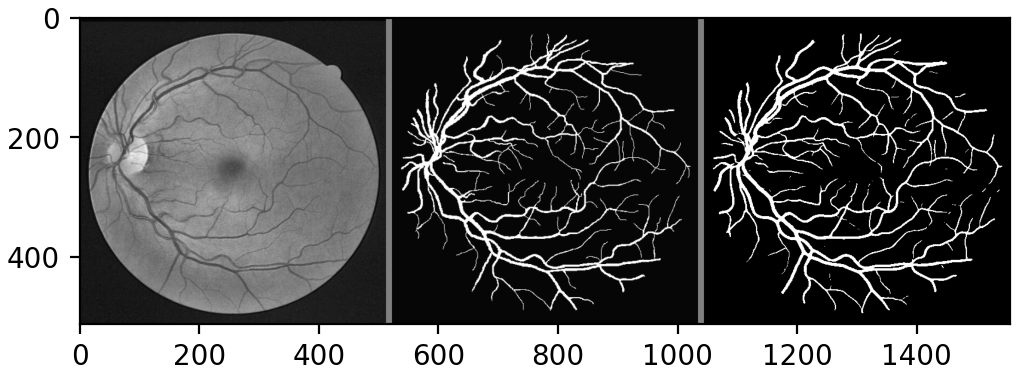

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Apr 26 02:01:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Project for INF899G Computer Vision Course


Retinal vision segmentation Using Unets architecture <br>
by Mohamad Hawchar HAWM20093305

## Importation and DataSets Downloading

In [ ]:
# dataSet
!unzip /content/drive/MyDrive/Project_CV/DataSet.zip


Archive:  /content/drive/MyDrive/Project_CV/DataSet.zip
   creating: DataSet/
   creating: DataSet/CHASEDB1/
   creating: DataSet/CHASEDB1/images/
  inflating: DataSet/CHASEDB1/images/Image_01L.jpg  
  inflating: DataSet/CHASEDB1/images/Image_01R.jpg  
  inflating: DataSet/CHASEDB1/images/Image_02L.jpg  
  inflating: DataSet/CHASEDB1/images/Image_02R.jpg  
  inflating: DataSet/CHASEDB1/images/Image_03L.jpg  
  inflating: DataSet/CHASEDB1/images/Image_03R.jpg  
  inflating: DataSet/CHASEDB1/images/Image_04L.jpg  
  inflating: DataSet/CHASEDB1/images/Image_04R.jpg  
  inflating: DataSet/CHASEDB1/images/Image_05L.jpg  
  inflating: DataSet/CHASEDB1/images/Image_05R.jpg  
  inflating: DataSet/CHASEDB1/images/Image_06L.jpg  
  inflating: DataSet/CHASEDB1/images/Image_06R.jpg  
  inflating: DataSet/CHASEDB1/images/Image_07L.jpg  
  inflating: DataSet/CHASEDB1/images/Image_07R.jpg  
  inflating: DataSet/CHASEDB1/images/Image_08L.jpg  
  inflating: DataSet/CHASEDB1/images/Image_08R.jpg  
  inf

In [ ]:
#importations
import numpy as np
import pandas as pd
import os
from glob import glob #exctrac the images
import time
from tqdm import tqdm # for the progress bar
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import imageio #read gifs
from albumentations import HorizontalFlip, VerticalFlip, Rotate # for applying augmentation
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 
import torchvision
from torchvision.transforms import transforms
from operator import add
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score, roc_auc_score
import random
import torch.nn.functional as F
import torch.nn.functional as nnf


## Data preparation

In [ ]:
#paths
dataset_path = '/content/DataSet'
chaseDB1_dataset_path = '/content/DataSet/CHASEDB1'
drive_dataset_path = '/content/DataSet/DRIVE'
stare_dataset_path = '/content/DataSet/STARE'

In [ ]:
""" Create a directory if it doesn't exist"""
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

""" Create directories to save the augmented data """
create_dir("new_data/train/image/")
create_dir("new_data/train/labels/")
create_dir("new_data/test/image/")
create_dir("new_data/test/labels/")

# hold the imported data, x for ground truth and y for the segmented image
train_x_combined = []
train_y_combined = []
test_x_combined = []
test_y_combined = []


In [ ]:
# loading Drive dataset
def load_Drive_dataset(path):
    train_x = sorted(glob(os.path.join(path, "training", "images", "*.tif")))
    train_y = sorted(glob(os.path.join(path, "training", "1st_manual", "*.gif")))
    test_x = sorted(glob(os.path.join(path, "test", "images", "*.tif")))
    test_y = sorted(glob(os.path.join(path, "test", "1st_manual", "*.gif")))

    return (train_x, train_y), (test_x, test_y)
    
(train_x_Drive, train_y_Drive), (test_x_Drive, test_y_Drive) = load_Drive_dataset(drive_dataset_path)   
print(f"Train dataset size: {len(train_x_Drive)} - {len(train_y_Drive)}")
print(f"Test dataset size: {len(test_x_Drive)} - {len(test_y_Drive)}")
print(train_x_Drive)
print(test_x_Drive)

train_x_combined += train_x_Drive
train_y_combined += train_y_Drive
test_x_combined += test_x_Drive
test_y_combined += test_y_Drive
print(f"Combined Train dataset size: {len(train_x_combined)} - {len(train_y_combined)}")
print(f"Combined Test dataset size: {len(test_x_combined)} - {len(test_y_combined)}")
print(train_x_combined)
print(test_x_combined)

Train dataset size: 20 - 20
Test dataset size: 20 - 20
['/content/DataSet/DRIVE/training/images/21_training.tif', '/content/DataSet/DRIVE/training/images/22_training.tif', '/content/DataSet/DRIVE/training/images/23_training.tif', '/content/DataSet/DRIVE/training/images/24_training.tif', '/content/DataSet/DRIVE/training/images/25_training.tif', '/content/DataSet/DRIVE/training/images/26_training.tif', '/content/DataSet/DRIVE/training/images/27_training.tif', '/content/DataSet/DRIVE/training/images/28_training.tif', '/content/DataSet/DRIVE/training/images/29_training.tif', '/content/DataSet/DRIVE/training/images/30_training.tif', '/content/DataSet/DRIVE/training/images/31_training.tif', '/content/DataSet/DRIVE/training/images/32_training.tif', '/content/DataSet/DRIVE/training/images/33_training.tif', '/content/DataSet/DRIVE/training/images/34_training.tif', '/content/DataSet/DRIVE/training/images/35_training.tif', '/content/DataSet/DRIVE/training/images/36_training.tif', '/content/DataSe

In [ ]:
# loading STARE dataset
def load_Stare_dataset(path):
    train_x = sorted(glob(os.path.join(path, "stare-images", "*.ppm")))
    
    train_y = sorted(glob(os.path.join(path, "labels-ah", "*.ppm")))

    return (train_x[0:15], train_y[0:15]), (train_x[15:], train_y[15:])
    
(train_x_Stare, train_y_Stare), (test_x_Stare, test_y_Stare) = load_Stare_dataset(stare_dataset_path)   
print(f"Train dataset size: {len(train_x_Stare)} - {len(train_y_Stare)}")
print(f"Test dataset size: {len(test_x_Stare)} - {len(test_y_Stare)}")
print(train_x_Stare)
print(test_x_Stare)

train_x_combined += train_x_Stare
train_y_combined += train_y_Stare
test_x_combined += test_x_Stare
test_y_combined += test_y_Stare
print(f"Combined Train dataset size: {len(train_x_combined)} - {len(train_y_combined)}")
print(f"Combined Test dataset size: {len(test_x_combined)} - {len(test_y_combined)}")
print(train_x_combined)
print(test_x_combined)

Train dataset size: 15 - 15
Test dataset size: 5 - 5
['/content/DataSet/STARE/stare-images/im0001.ppm', '/content/DataSet/STARE/stare-images/im0002.ppm', '/content/DataSet/STARE/stare-images/im0003.ppm', '/content/DataSet/STARE/stare-images/im0004.ppm', '/content/DataSet/STARE/stare-images/im0005.ppm', '/content/DataSet/STARE/stare-images/im0044.ppm', '/content/DataSet/STARE/stare-images/im0077.ppm', '/content/DataSet/STARE/stare-images/im0081.ppm', '/content/DataSet/STARE/stare-images/im0082.ppm', '/content/DataSet/STARE/stare-images/im0139.ppm', '/content/DataSet/STARE/stare-images/im0162.ppm', '/content/DataSet/STARE/stare-images/im0163.ppm', '/content/DataSet/STARE/stare-images/im0235.ppm', '/content/DataSet/STARE/stare-images/im0236.ppm', '/content/DataSet/STARE/stare-images/im0239.ppm']
['/content/DataSet/STARE/stare-images/im0240.ppm', '/content/DataSet/STARE/stare-images/im0255.ppm', '/content/DataSet/STARE/stare-images/im0291.ppm', '/content/DataSet/STARE/stare-images/im0319.p

In [ ]:
# loading CHASEDB1 dataset
def load_ChaseDB1_dataset(path):
    train_x = sorted(glob(os.path.join(path, "images", "*.jpg")))
    
    train_y = sorted(glob(os.path.join(path, "labels1", "*.png")))

    return (train_x[0:20], train_y[0:20]), (train_x[20:], train_y[20:])
    
(train_x_ChaseDB, train_y_ChaseDB), (test_x_ChaseDB, test_y_ChaseDB) = load_ChaseDB1_dataset(chaseDB1_dataset_path)   
print(f"Train dataset size: {len(train_x_ChaseDB)} - {len(train_y_ChaseDB)}")
print(f"Test dataset size: {len(test_x_ChaseDB)} - {len(test_y_ChaseDB)}")
print(train_x_ChaseDB)
print(test_x_ChaseDB)

train_x_combined += train_x_ChaseDB
train_y_combined += train_y_ChaseDB
test_x_combined += test_x_ChaseDB
test_y_combined += test_y_ChaseDB
print(f"Combined Train dataset size: {len(train_x_combined)} - {len(train_y_combined)}")
print(f"Combined Test dataset size: {len(test_x_combined)} - {len(test_y_combined)}")
print(train_x_combined)
print(test_x_combined)

Train dataset size: 20 - 20
Test dataset size: 8 - 8
['/content/DataSet/CHASEDB1/images/Image_01L.jpg', '/content/DataSet/CHASEDB1/images/Image_01R.jpg', '/content/DataSet/CHASEDB1/images/Image_02L.jpg', '/content/DataSet/CHASEDB1/images/Image_02R.jpg', '/content/DataSet/CHASEDB1/images/Image_03L.jpg', '/content/DataSet/CHASEDB1/images/Image_03R.jpg', '/content/DataSet/CHASEDB1/images/Image_04L.jpg', '/content/DataSet/CHASEDB1/images/Image_04R.jpg', '/content/DataSet/CHASEDB1/images/Image_05L.jpg', '/content/DataSet/CHASEDB1/images/Image_05R.jpg', '/content/DataSet/CHASEDB1/images/Image_06L.jpg', '/content/DataSet/CHASEDB1/images/Image_06R.jpg', '/content/DataSet/CHASEDB1/images/Image_07L.jpg', '/content/DataSet/CHASEDB1/images/Image_07R.jpg', '/content/DataSet/CHASEDB1/images/Image_08L.jpg', '/content/DataSet/CHASEDB1/images/Image_08R.jpg', '/content/DataSet/CHASEDB1/images/Image_09L.jpg', '/content/DataSet/CHASEDB1/images/Image_09R.jpg', '/content/DataSet/CHASEDB1/images/Image_10L.jp

## Pretreatment & augmentation

In [ ]:
# CLAHE function
def clahe_equalized(imgs):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(imgs)
    return img

    
#normalize over the dataset
def dataset_normalized(imgs):
    imgs_std = np.std(imgs)
    imgs_mean = np.mean(imgs)
    imgs_normalized = (imgs-imgs_mean)/imgs_std

    return imgs_normalized

def adjust_gamma(imgs, gamma=1.0):

    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    imgs = cv2.LUT(imgs, table)
    return imgs


100%|██████████| 47/47 [00:01<00:00, 45.10it/s]


(-0.5, 511.5, 511.5, -0.5)

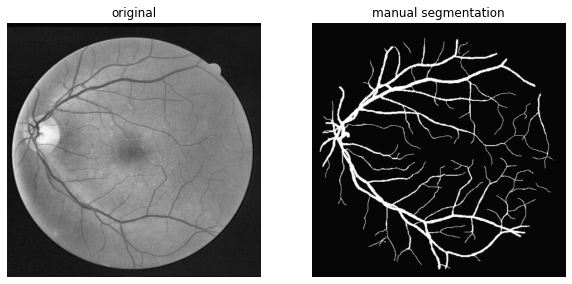

In [ ]:
#Preprocessing
# -Augmentation
# -Zscore Standardization
# -(CLAHE) Contrast-limited adaptive histogram equalization
# -Gamma adjustment.

def preprocess_data(images, labels, save_path, augment=True, width = 512, height = 512):
    size = (width, height)

    for idx, (x, y) in tqdm(enumerate(zip(images, labels)), total=len(images)):
        """ Extracting the name """
        name = x.split("/")[-1].split(".")[0]

        """ Reading image and mask """
        x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)

        # Dealing with the annoying format opening problems between libraries......
        if y.endswith('gif') == True:
          y = imageio.mimread(y)[0]
        else:
          y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        

        if augment == True:
            aug = HorizontalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x1 = augmented["image"]
            y1 = augmented["mask"]

            aug = VerticalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x2 = augmented["image"]
            y2 = augmented["mask"]

            aug = Rotate(limit=45, p=1.0)
            augmented = aug(image=x, mask=y)
            x3 = augmented["image"]
            y3 = augmented["mask"]

            X = [x, x1,x2,x3]
            Y = [y, y1,y2,y3]

        else:
            X = [x]
            Y = [y]

          

        index = 0
        for i, m in zip(X, Y):
            i = cv2.resize(i, size)
            m = cv2.resize(m, size)

            # z-score normalization
            #m = dataset_normalized(m)
            #print( m.shape, m)
            #i = dataset_normalized(i)
            #Clahe function
            m = clahe_equalized(m)
            i = clahe_equalized(i)


            m = adjust_gamma(m, 1.2)
            i = adjust_gamma(i, 1.2)

            tmp_image_name = f"{name}_{index}.png"
            tmp_label_name = f"{name}_{index}.png"

            image_path = os.path.join(save_path, "image", tmp_image_name)
            label_path = os.path.join(save_path, "labels", tmp_label_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(label_path, m)

            index += 1
# train_x_Drive, train_y_ChaseDB, train_y_Stare
preprocess_data(train_x_combined, train_y_combined, "new_data/train/", augment=True, width = 512, height = 512)
preprocess_data(test_x_combined, test_y_combined, "new_data/test/", augment=False, width = 512, height = 512)


fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)
  
# showing image
plt.imshow(cv2.imread("/content/new_data/train/image/21_training_0.png"))
plt.axis('off')
plt.title("original")

fig.add_subplot(1, 2, 2)
  
# showing image
plt.imshow(cv2.imread("/content/new_data/train/labels/21_training_0.png"))
plt.title("manual segmentation")
plt.axis('off')


In [ ]:
# ! rm -r '/content/new_data'

## Architectures

### U-net 

In [ ]:
class convolution_block(nn.Module):
  def __init__(self,in_c,out_c):
    super().__init__()
    
    self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(out_c)

    self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(out_c)

    self.relu = nn.ReLU()


  def forward(self,inputs):
    x = self.conv1(inputs)
    x = self.bn1(x)
    x = self.relu(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)

    return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = convolution_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = convolution_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = convolution_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)

        return outputs


# x = torch.randn((2,3,512,512))
# f = build_unet()
# y= f(x)

# print(y.shape)
    

### Attention U-net

In [ ]:
class conv_block(nn.Module):

    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):

        x = self.conv(x)
        return x


class up_conv(nn.Module):

    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x




class Attention_block(nn.Module):


    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out


class AttU_Net(nn.Module):

    def __init__(self, img_ch=3, output_ch=1):
        super(AttU_Net, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(img_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)

        #self.active = torch.nn.Sigmoid()


    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)

        #print(x5.shape)
        d5 = self.Up5(e5)
        #print(d5.shape)
        x4 = self.Att5(g=d5, x=e4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)

      #  out = self.active(out)

        return out

### Nested U-net

In [ ]:

class conv_block_nested(nn.Module):
    
    def __init__(self, in_ch, mid_ch, out_ch):
        super(conv_block_nested, self).__init__()
        self.activation = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_ch, mid_ch, kernel_size=3, padding=1, bias=True)
        self.bn1 = nn.BatchNorm2d(mid_ch)
        self.conv2 = nn.Conv2d(mid_ch, out_ch, kernel_size=3, padding=1, bias=True)
        self.bn2 = nn.BatchNorm2d(out_ch)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        output = self.activation(x)

        return output
    
#Nested Unet

class NestedUNet(nn.Module):

    def __init__(self, in_ch=3, out_ch=1):
        super(NestedUNet, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = conv_block_nested(in_ch, filters[0], filters[0])
        self.conv1_0 = conv_block_nested(filters[0], filters[1], filters[1])
        self.conv2_0 = conv_block_nested(filters[1], filters[2], filters[2])
        self.conv3_0 = conv_block_nested(filters[2], filters[3], filters[3])
        self.conv4_0 = conv_block_nested(filters[3], filters[4], filters[4])

        self.conv0_1 = conv_block_nested(filters[0] + filters[1], filters[0], filters[0])
        self.conv1_1 = conv_block_nested(filters[1] + filters[2], filters[1], filters[1])
        self.conv2_1 = conv_block_nested(filters[2] + filters[3], filters[2], filters[2])
        self.conv3_1 = conv_block_nested(filters[3] + filters[4], filters[3], filters[3])

        self.conv0_2 = conv_block_nested(filters[0]*2 + filters[1], filters[0], filters[0])
        self.conv1_2 = conv_block_nested(filters[1]*2 + filters[2], filters[1], filters[1])
        self.conv2_2 = conv_block_nested(filters[2]*2 + filters[3], filters[2], filters[2])

        self.conv0_3 = conv_block_nested(filters[0]*3 + filters[1], filters[0], filters[0])
        self.conv1_3 = conv_block_nested(filters[1]*3 + filters[2], filters[1], filters[1])

        self.conv0_4 = conv_block_nested(filters[0]*4 + filters[1], filters[0], filters[0])

        self.final = nn.Conv2d(filters[0], out_ch, kernel_size=1)


    def forward(self, x):
        
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.Up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.Up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.Up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.Up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.Up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.Up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.Up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.Up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.Up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.Up(x1_3)], 1))

        output = self.final(x0_4)
        return output


## Utils

In [ ]:
""" Seeding the random """
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

""" Create a directory. """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

""" Calculate the time taken """
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

In [ ]:
class Dataset(Dataset):
    def __init__(self, images_path, masks_path):

        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        """ Reading image """
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        image = image/255.0 ## (512, 512, 3)
        image = np.transpose(image, (2, 0, 1))  ## (3, 512, 512)
        image = image.astype(np.float32)
        image = torch.from_numpy(image)

        """ Reading mask """
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
        mask = mask/255.0   ## (512, 512)
        mask = np.expand_dims(mask, axis=0) ## (1, 512, 512)
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask

    def __len__(self):
        return self.n_samples

## Training

In [ ]:

def train(model, loader, optimizer, loss_fn, device):
    sum_loss = 0.0
    model.train()
    for x, y in loader:
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        # Initialiser les paramètres des gradients à zéro
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward() # autograd magic ! Calcule toutes les dérivées partielles
        optimizer.step() # Effectue un pas dans la direction du gradient

        
        sum_loss += loss.item()

    sum_loss = sum_loss/len(loader)
    
    return sum_loss

def evaluate(model, loader, loss_fn, device):
    sum_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            sum_loss += loss.item()

        sum_loss = sum_loss/len(loader)
    return sum_loss

def smooth(x, size):
    return np.convolve(x, np.ones(size)/size, mode='valid')

In [ ]:
def fully_train(net, model_name):
    """ Seeding """
    seeding(42)

    """ Directories """
    create_dir("files")

    """ Load dataset """
    train_x = sorted(glob("/content/new_data/train/image/*"))
    train_y = sorted(glob("/content/new_data/train/labels/*"))

    valid_x = sorted(glob("/content/new_data/test/image/*"))
    valid_y = sorted(glob("/content/new_data/test/labels/*"))

    data_str = f"Dataset Size:\nTrain: {len(train_x)} - Valid: {len(valid_x)}\n"
    print(data_str)

    """ Hyperparameters """
    H = 512
    W = 512
    size = (H, W)
    batch_size = 2
    num_epochs = 50
    lr = 1e-4
    checkpoint_path = f"files/{model_name}.pth"

    """ Dataset and loader """
    train_dataset = Dataset(train_x, train_y)
    valid_dataset = Dataset(valid_x, valid_y)

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )

    device = torch.device('cuda')   
    model = net()
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
    loss_fn = DiceBCELoss()
    #loss_fn = DiceLoss()
    #loss_fn = nn.CrossEntropyLoss()

    """ Training the model """
    best_valid_loss = float("inf")
    train_losses = []
    valid_losses = []
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss = train(model, train_loader, optimizer, loss_fn, device)
        valid_loss = evaluate(model, valid_loader, loss_fn, device)

        """ Saving the model """
        if valid_loss < best_valid_loss:
            data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: {checkpoint_path}"
            print(data_str)

            best_valid_loss = valid_loss
            torch.save(model.state_dict(), checkpoint_path)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n'
        data_str += f'\tTrain Loss: {train_loss:.3f}\n'
        data_str += f'\t Val. Loss: {valid_loss:.3f}\n'

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        print(data_str)
    plt.plot(smooth(train_losses,1), 'r-',label='training')
    plt.plot(smooth(valid_losses, 1), 'b-',label='validation')
    return train_losses,valid_losses

## Testing

In [ ]:
def calculate_metrics(y_true, y_pred , y_score):
  
    """ Ground truth """
    y_true = y_true.cpu().numpy()
    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)
    
    """ Score """
    y_score = y_score.cpu().numpy()
    y_score = y_score > 0.5
    y_score = y_score.astype(np.uint8)
    y_score = y_score.reshape(-1)
    # #y_score = y_score/255
    # print(y_score)

    """ Prediction """
    y_pred = y_pred.cpu().numpy()
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    score_jaccard = jaccard_score(y_true, y_pred)
    score_f1 = f1_score(y_true, y_pred)
    score_recall = recall_score(y_true, y_pred)
    score_precision = precision_score(y_true, y_pred)
    score_acc = accuracy_score(y_true, y_pred)
    score_roc = roc_auc_score(y_true, y_score)

    return [score_jaccard, score_f1, score_recall, score_precision, score_acc,score_roc]

def mask_parse(mask):
    mask = np.expand_dims(mask, axis=-1)    ## (512, 512, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)
    return mask

In [ ]:
def fully_test(net,model_name):

      """ Seeding """
      seeding(42)

      """ Folders """
      create_dir("results")
      create_dir(f"results/{model_name}")

      """ Load dataset """
      test_x = sorted(glob("/content/new_data/test/image/*"))
      test_y = sorted(glob("/content/new_data/test/labels/*"))

      """ Hyperparameters """
      H = 512
      W = 512
      size = (W, H)
      checkpoint_path = f"files/{model_name}.pth"

      """ Load the checkpoint """
      device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

      model = net()
      model = model.to(device)
      model.load_state_dict(torch.load(checkpoint_path, map_location=device))
      model.eval()

      metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0,0.0]
      time_taken = []

      for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
              """ Extract the name """
              name = x.split("/")[-1].split(".")[0]

              """ Reading image """
              image = cv2.imread(x, cv2.IMREAD_COLOR) ## (512, 512, 3)
              ## image = cv2.resize(image, size)
              x = np.transpose(image, (2, 0, 1))      ## (3, 512, 512)
              x = x/255.0
              x = np.expand_dims(x, axis=0)           ## (1, 3, 512, 512)
              x = x.astype(np.float32)
              x = torch.from_numpy(x)
              x = x.to(device)

              """ Reading mask """
              mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
              ## mask = cv2.resize(mask, size)
              y = np.expand_dims(mask, axis=0)            ## (1, 512, 512)
              y = y/255.0
              y = np.expand_dims(y, axis=0)               ## (1, 1, 512, 512)
              y = y.astype(np.float32)
              y = torch.from_numpy(y)
              y = y.to(device)

              with torch.no_grad():
                  """ Prediction and Calculating FPS """
                  start_time = time.time()
                  pred_y = model(x)
                  y_prob = pred_y
                  pred_y = torch.sigmoid(pred_y)
                  total_time = time.time() - start_time
                  time_taken.append(total_time)


                  score = calculate_metrics(y, pred_y, y_prob)
                  metrics_score = list(map(add, metrics_score, score))
                  pred_y = pred_y[0].cpu().numpy()        ## (1, 512, 512)
                  pred_y = np.squeeze(pred_y, axis=0)     ## (512, 512)
                  pred_y = pred_y > 0.5
                  pred_y = np.array(pred_y, dtype=np.uint8)

              """ Saving masks """
              ori_mask = mask_parse(mask)
              pred_y = mask_parse(pred_y)
              
              
              line = np.ones((size[1], 10, 3)) * 128

              cat_images = np.concatenate(
                  [image, line, ori_mask, line, pred_y * 255], axis=1
              )
              cv2.imwrite(f"results/{model_name}/{name}.png", cat_images)

      jaccard = metrics_score[0]/len(test_x)
      f1 = metrics_score[1]/len(test_x)
      recall = metrics_score[2]/len(test_x)
      precision = metrics_score[3]/len(test_x)
      acc = metrics_score[4]/len(test_x)
      roc = metrics_score[5]/len(test_x)
      print(f"Jaccard: {jaccard:1.4f} - F1: {f1:1.4f} - Recall: {recall:1.4f} - Precision: {precision:1.4f} - Acc: {acc:1.4f} - ROC-AUC : {roc:1.4f}")

      fps = 1/np.mean(time_taken)
      print("FPS: ", fps)

## Models Training, Testing & Results

### Unet Results

Dataset Size:
Train: 220 - Valid: 39

Valid loss improved from inf to 0.9296. Saving checkpoint: files/unet.pth
Epoch: 01 | Epoch Time: 1m 38s
	Train Loss: 1.041
	 Val. Loss: 0.930

Valid loss improved from 0.9296 to 0.8535. Saving checkpoint: files/unet.pth
Epoch: 02 | Epoch Time: 1m 44s
	Train Loss: 0.881
	 Val. Loss: 0.854

Valid loss improved from 0.8535 to 0.7862. Saving checkpoint: files/unet.pth
Epoch: 03 | Epoch Time: 1m 46s
	Train Loss: 0.801
	 Val. Loss: 0.786

Valid loss improved from 0.7862 to 0.7511. Saving checkpoint: files/unet.pth
Epoch: 04 | Epoch Time: 1m 46s
	Train Loss: 0.738
	 Val. Loss: 0.751

Valid loss improved from 0.7511 to 0.6923. Saving checkpoint: files/unet.pth
Epoch: 05 | Epoch Time: 1m 46s
	Train Loss: 0.687
	 Val. Loss: 0.692

Valid loss improved from 0.6923 to 0.6539. Saving checkpoint: files/unet.pth
Epoch: 06 | Epoch Time: 1m 46s
	Train Loss: 0.648
	 Val. Loss: 0.654

Valid loss improved from 0.6539 to 0.6185. Saving checkpoint: files/unet.pth
Epoch:

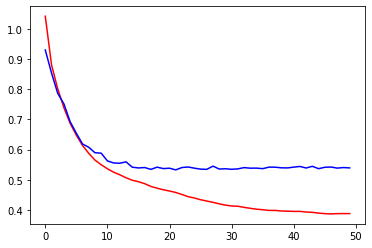

In [ ]:
tl_UNet,vl_UNet =fully_train(build_unet,"unet")

100%|██████████| 39/39 [00:20<00:00,  1.90it/s]

Jaccard: 0.6869 - F1: 0.8136 - Recall: 0.8599 - Precision: 0.7755 - Acc: 0.9690 - ROC-AUC : 0.9125
FPS:  123.11314922565948


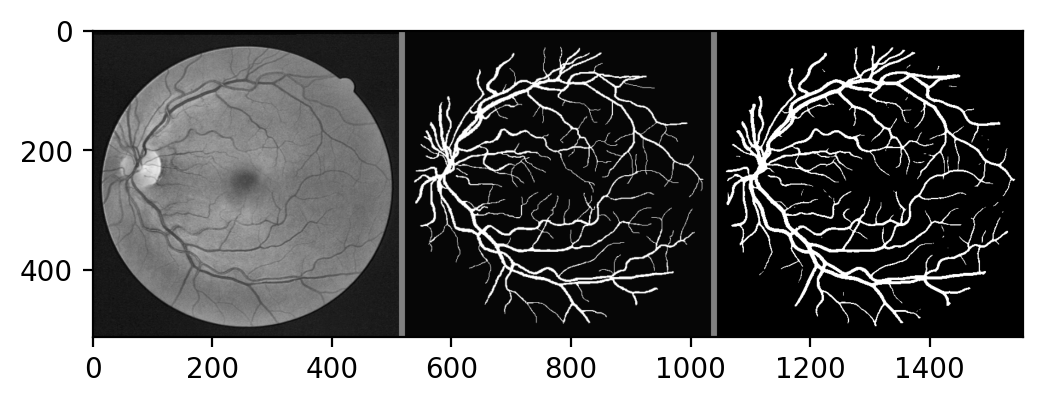

In [ ]:
fully_test(build_unet,"unet")
plt.figure(dpi = 200)
plt.imshow(cv2.imread("/content/results/unet/01_test_0.png"))

### Attention Unet Resutls

Dataset Size:
Train: 220 - Valid: 39

Valid loss improved from inf to 1.0584. Saving checkpoint: files/attention_unet.pth
Epoch: 01 | Epoch Time: 2m 14s
	Train Loss: 1.148
	 Val. Loss: 1.058

Valid loss improved from 1.0584 to 0.9666. Saving checkpoint: files/attention_unet.pth
Epoch: 02 | Epoch Time: 2m 20s
	Train Loss: 1.000
	 Val. Loss: 0.967

Valid loss improved from 0.9666 to 0.9068. Saving checkpoint: files/attention_unet.pth
Epoch: 03 | Epoch Time: 2m 21s
	Train Loss: 0.925
	 Val. Loss: 0.907

Valid loss improved from 0.9068 to 0.8470. Saving checkpoint: files/attention_unet.pth
Epoch: 04 | Epoch Time: 2m 21s
	Train Loss: 0.860
	 Val. Loss: 0.847

Valid loss improved from 0.8470 to 0.8003. Saving checkpoint: files/attention_unet.pth
Epoch: 05 | Epoch Time: 2m 21s
	Train Loss: 0.804
	 Val. Loss: 0.800

Valid loss improved from 0.8003 to 0.7472. Saving checkpoint: files/attention_unet.pth
Epoch: 06 | Epoch Time: 2m 21s
	Train Loss: 0.755
	 Val. Loss: 0.747

Valid loss improved fro

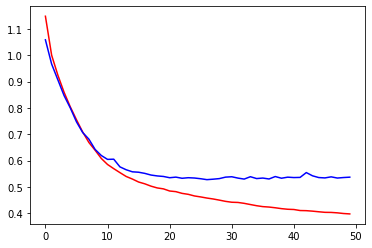

In [ ]:
# attention unet
tl_AttU_Net,vl_AttU_Net = fully_train(AttU_Net,"attention_unet")

100%|██████████| 39/39 [00:19<00:00,  2.00it/s]

Jaccard: 0.6951 - F1: 0.8194 - Recall: 0.8414 - Precision: 0.8026 - Acc: 0.9708 - ROC-AUC : 0.9049
FPS:  86.40548675165414


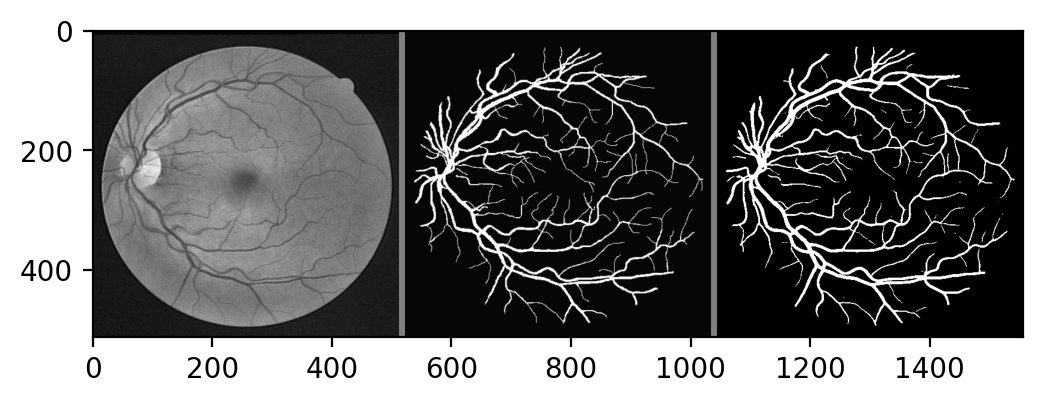

In [ ]:
fully_test(AttU_Net,"attention_unet") 
plt.figure(dpi = 200)
plt.imshow(cv2.imread("/content/results/attention_unet/01_test_0.png"))

### Nested Unet Results

Dataset Size:
Train: 220 - Valid: 39

Valid loss improved from inf to 0.8582. Saving checkpoint: files/nested_unet.pth
Epoch: 01 | Epoch Time: 4m 42s
	Train Loss: 0.933
	 Val. Loss: 0.858

Valid loss improved from 0.8582 to 0.7827. Saving checkpoint: files/nested_unet.pth
Epoch: 02 | Epoch Time: 4m 42s
	Train Loss: 0.800
	 Val. Loss: 0.783

Valid loss improved from 0.7827 to 0.7121. Saving checkpoint: files/nested_unet.pth
Epoch: 03 | Epoch Time: 4m 42s
	Train Loss: 0.726
	 Val. Loss: 0.712

Valid loss improved from 0.7121 to 0.6711. Saving checkpoint: files/nested_unet.pth
Epoch: 04 | Epoch Time: 4m 42s
	Train Loss: 0.671
	 Val. Loss: 0.671

Valid loss improved from 0.6711 to 0.6456. Saving checkpoint: files/nested_unet.pth
Epoch: 05 | Epoch Time: 4m 41s
	Train Loss: 0.632
	 Val. Loss: 0.646

Valid loss improved from 0.6456 to 0.6124. Saving checkpoint: files/nested_unet.pth
Epoch: 06 | Epoch Time: 4m 41s
	Train Loss: 0.600
	 Val. Loss: 0.612

Valid loss improved from 0.6124 to 0.5907

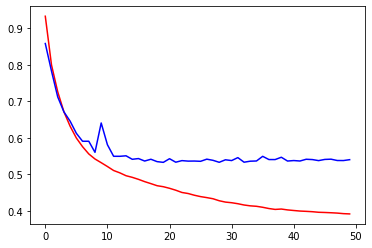

In [ ]:
# nested unet
tl_NestedUNet,vl_NestedUNet = fully_train(NestedUNet,"nested_unet")

100%|██████████| 39/39 [00:26<00:00,  1.45it/s]

Jaccard: 0.6889 - F1: 0.8152 - Recall: 0.8316 - Precision: 0.8034 - Acc: 0.9704 - ROC-AUC : 0.8988
FPS:  87.934588452346


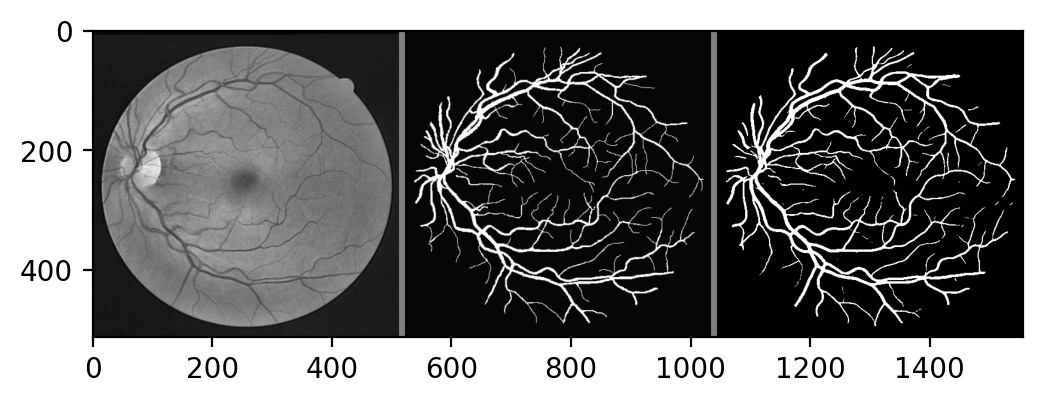

In [ ]:
fully_test(NestedUNet,"nested_unet")
plt.figure(dpi = 200)
plt.imshow(cv2.imread("/content/results/nested_unet/01_test_0.png"))

## comparasion

<function matplotlib.pyplot.show>

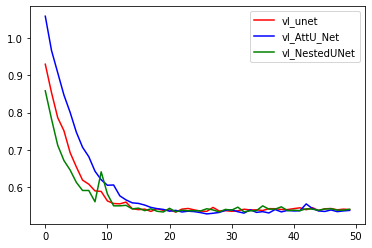

In [ ]:
#
plt.plot(smooth(vl_UNet,1), 'r-',label='vl_unet')
plt.plot(smooth(vl_AttU_Net, 1), 'b-',label='vl_AttU_Net')
#plt.plot(smooth(vl_R2U_Net, 1), 'g-',label='vl_R2U_Net')
plt.plot(smooth(vl_NestedUNet, 1), 'g-',label='vl_NestedUNet')
plt.legend()
plt.show

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()

5406

In [ ]:
cp -av '/content/results' '/content/drive/MyDrive/Retinal_vessel-segmentation'

'/content/results' -> '/content/drive/MyDrive/Retinal_vessel-segmentation/results'
'/content/results/unet' -> '/content/drive/MyDrive/Retinal_vessel-segmentation/results/unet'
'/content/results/unet/01_test_0.png' -> '/content/drive/MyDrive/Retinal_vessel-segmentation/results/unet/01_test_0.png'
'/content/results/unet/02_test_0.png' -> '/content/drive/MyDrive/Retinal_vessel-segmentation/results/unet/02_test_0.png'
'/content/results/unet/03_test_0.png' -> '/content/drive/MyDrive/Retinal_vessel-segmentation/results/unet/03_test_0.png'
'/content/results/unet/04_test_0.png' -> '/content/drive/MyDrive/Retinal_vessel-segmentation/results/unet/04_test_0.png'
'/content/results/unet/05_test_0.png' -> '/content/drive/MyDrive/Retinal_vessel-segmentation/results/unet/05_test_0.png'
'/content/results/unet/06_test_0.png' -> '/content/drive/MyDrive/Retinal_vessel-segmentation/results/unet/06_test_0.png'
'/content/results/unet/07_test_0.png' -> '/content/drive/MyDrive/Retinal_vessel-segmentation/resul

In [ ]:
cp -av '/content/files' '/content/drive/MyDrive/Retinal_vessel-segmentation'


'/content/files' -> '/content/drive/MyDrive/Retinal_vessel-segmentation/files'
'/content/files/unet.pth' -> '/content/drive/MyDrive/Retinal_vessel-segmentation/files/unet.pth'
'/content/files/attention_unet.pth' -> '/content/drive/MyDrive/Retinal_vessel-segmentation/files/attention_unet.pth'
'/content/files/nested_unet.pth' -> '/content/drive/MyDrive/Retinal_vessel-segmentation/files/nested_unet.pth'
'/content/files/results' -> '/content/drive/MyDrive/Retinal_vessel-segmentation/files/results'
'/content/files/results/unet' -> '/content/drive/MyDrive/Retinal_vessel-segmentation/files/results/unet'
'/content/files/results/unet/01_test_0.png' -> '/content/drive/MyDrive/Retinal_vessel-segmentation/files/results/unet/01_test_0.png'
'/content/files/results/unet/02_test_0.png' -> '/content/drive/MyDrive/Retinal_vessel-segmentation/files/results/unet/02_test_0.png'
'/content/files/results/unet/03_test_0.png' -> '/content/drive/MyDrive/Retinal_vessel-segmentation/files/results/unet/03_test_0.pn

In [ ]:
cp -av '/content/new_data' '/content/drive/MyDrive/Retinal_vessel-segmentation'

'/content/new_data' -> '/content/drive/MyDrive/Retinal_vessel-segmentation/new_data'
'/content/new_data/train' -> '/content/drive/MyDrive/Retinal_vessel-segmentation/new_data/train'
'/content/new_data/train/image' -> '/content/drive/MyDrive/Retinal_vessel-segmentation/new_data/train/image'
'/content/new_data/train/image/21_training_0.png' -> '/content/drive/MyDrive/Retinal_vessel-segmentation/new_data/train/image/21_training_0.png'
'/content/new_data/train/image/21_training_1.png' -> '/content/drive/MyDrive/Retinal_vessel-segmentation/new_data/train/image/21_training_1.png'
'/content/new_data/train/image/21_training_2.png' -> '/content/drive/MyDrive/Retinal_vessel-segmentation/new_data/train/image/21_training_2.png'
'/content/new_data/train/image/21_training_3.png' -> '/content/drive/MyDrive/Retinal_vessel-segmentation/new_data/train/image/21_training_3.png'
'/content/new_data/train/image/22_training_0.png' -> '/content/drive/MyDrive/Retinal_vessel-segmentation/new_data/train/image/22_